In [1]:
import os
import torch
import numpy as np
import pandas as pd

from sklearn.metrics import confusion_matrix
from utils.graph import draw_confusion_matrix
from utils.configs import config
from utils.data_loader import get_test_loader
from utils.model_list import xception
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from openmax.openmax import compute_openmax
from openmax.openmax_utils import (
    get_openmax_predict_int,
    get_openmax_predict_bin,
    get_int_labels,
    get_bin_labels,
    compute_roc,
    compute_pr,
    plot_roc,
    plot_pr,
)

In [2]:
device = torch.device('cuda:0')

In [3]:
net = xception(config=config)

Using Xception with 16 classes
Loading pretrained weights...


In [4]:
net.load_state_dict(torch.load(f'model_weights/fold_{config.fold}/model.pth'))

<All keys matched successfully>

In [5]:
net.to(device)
net.eval()

Xception(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (block1): Block(
    (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (rep): Sequential(
      (0): SeparableConv2d(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): SeparableConv2d(
        (conv1): Co

In [6]:
test_dl, class_map = get_test_loader(config)

In [7]:
for k, v in class_map.items():
    class_map[k] = v.capitalize()

In [8]:
for k in range(16, len(class_map)):
    class_map.pop(k, None)

class_map[16] = 'Unknown'

In [9]:
openmax = []
prob_u = []
y_true = []

with torch.no_grad():
    for data in test_dl:
        x = data[0].to(device)
        labels = data[1].cpu().numpy()
        out = net(x).cpu().numpy()

        for logits, label in zip(out, labels):
            temp_openmax, temp_prob_u = compute_openmax(logits, config.fold)
            openmax.append(temp_openmax)
            prob_u.append(temp_prob_u)
            y_true.append(label)

In [10]:
y_true = np.asarray(y_true)

In [11]:
y_true_bin = get_bin_labels(y_true)
y_true_int = get_int_labels(y_true)

In [12]:
roc = compute_roc(y_true_bin, prob_u)
pr = compute_pr(y_true_bin, prob_u)

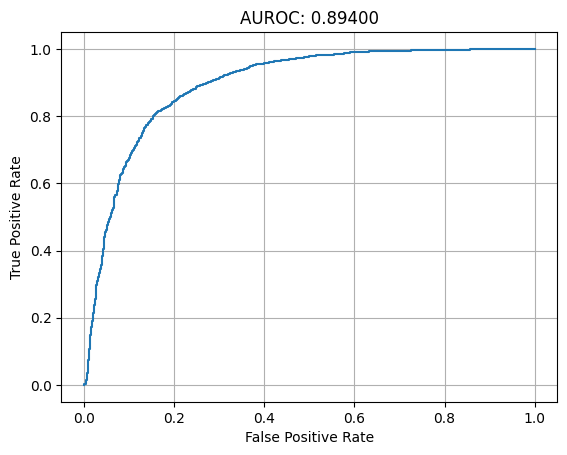

In [13]:
plot_roc(roc)

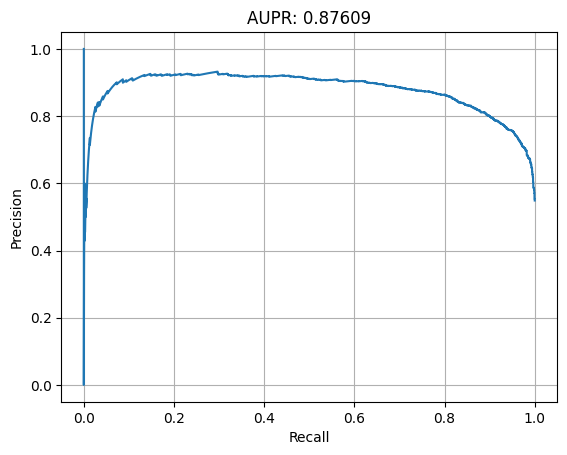

In [14]:
plot_pr(pr)

In [15]:
roc_thresholds = roc['thresholds']
pr_thresholds = pr['thresholds']

In [16]:
best_idx = np.argmax(roc['tpr'] - roc['fpr'])
best_thresh = roc_thresholds[best_idx]

In [17]:
# best_idx = np.argmax(pr['f1'])
# best_thresh = pr_thresholds[best_idx]

In [18]:
def get_unique(arr):
    unique, counts = np.unique(arr, return_counts=True)
    print(dict(zip(unique, counts)))

In [19]:
y_pred_bin = []
for probs in openmax:
    temp = get_openmax_predict_bin(probs, threshold=best_thresh)
    y_pred_bin.append(temp)
y_pred_bin = np.asarray(y_pred_bin)

In [20]:
f1_bin = f1_score(y_true_bin, y_pred_bin)
pre_bin = precision_score(y_true_bin, y_pred_bin)
rec_bin = recall_score(y_true_bin, y_pred_bin)
acc_bin = accuracy_score(y_true_bin, y_pred_bin)

In [21]:
diff = y_true_bin - y_pred_bin
get_unique(diff)

{-1: 251, 0: 2791, 1: 347}


In [22]:
get_unique(y_true_bin)
get_unique(y_pred_bin)

{0: 1529, 1: 1860}
{0: 1625, 1: 1764}


In [23]:
y_pred_int = []
for probs in openmax:
    temp = get_openmax_predict_int(probs, threshold=best_thresh)
    y_pred_int.append(temp)
y_pred_int = np.asarray(y_pred_int)

In [24]:
probs

array([3.53721548e-12, 2.27880275e-12, 2.82037548e-21, 2.18945290e-11,
       1.15239936e-22, 1.22296892e-10, 2.07654663e-21, 5.49980220e-15,
       9.70703631e-06, 1.26758180e-10, 1.00814914e-11, 8.54062576e-01,
       7.76783130e-03, 2.93629245e-02, 8.67043696e-24, 3.35957109e-11,
       1.08796960e-01])

In [25]:
get_unique(y_true_int)
get_unique(y_pred_int)

{0: 139, 1: 104, 2: 49, 3: 166, 4: 61, 5: 52, 6: 24, 7: 61, 8: 86, 9: 180, 10: 186, 11: 46, 12: 238, 13: 22, 14: 65, 15: 50, 16: 1860}
{0: 133, 1: 130, 2: 62, 3: 158, 4: 55, 5: 54, 6: 25, 7: 62, 8: 118, 9: 150, 10: 168, 11: 31, 12: 235, 13: 11, 14: 66, 15: 167, 16: 1764}


In [26]:
cm = confusion_matrix(y_true_int, y_pred_int, normalize='true')

In [27]:
cm_df = pd.DataFrame(cm, index=class_map.values(), columns=class_map.values())
cm_df.to_csv(f'results/cm_fold_{config.fold}.csv')

In [28]:
cm = np.round(cm, 2)

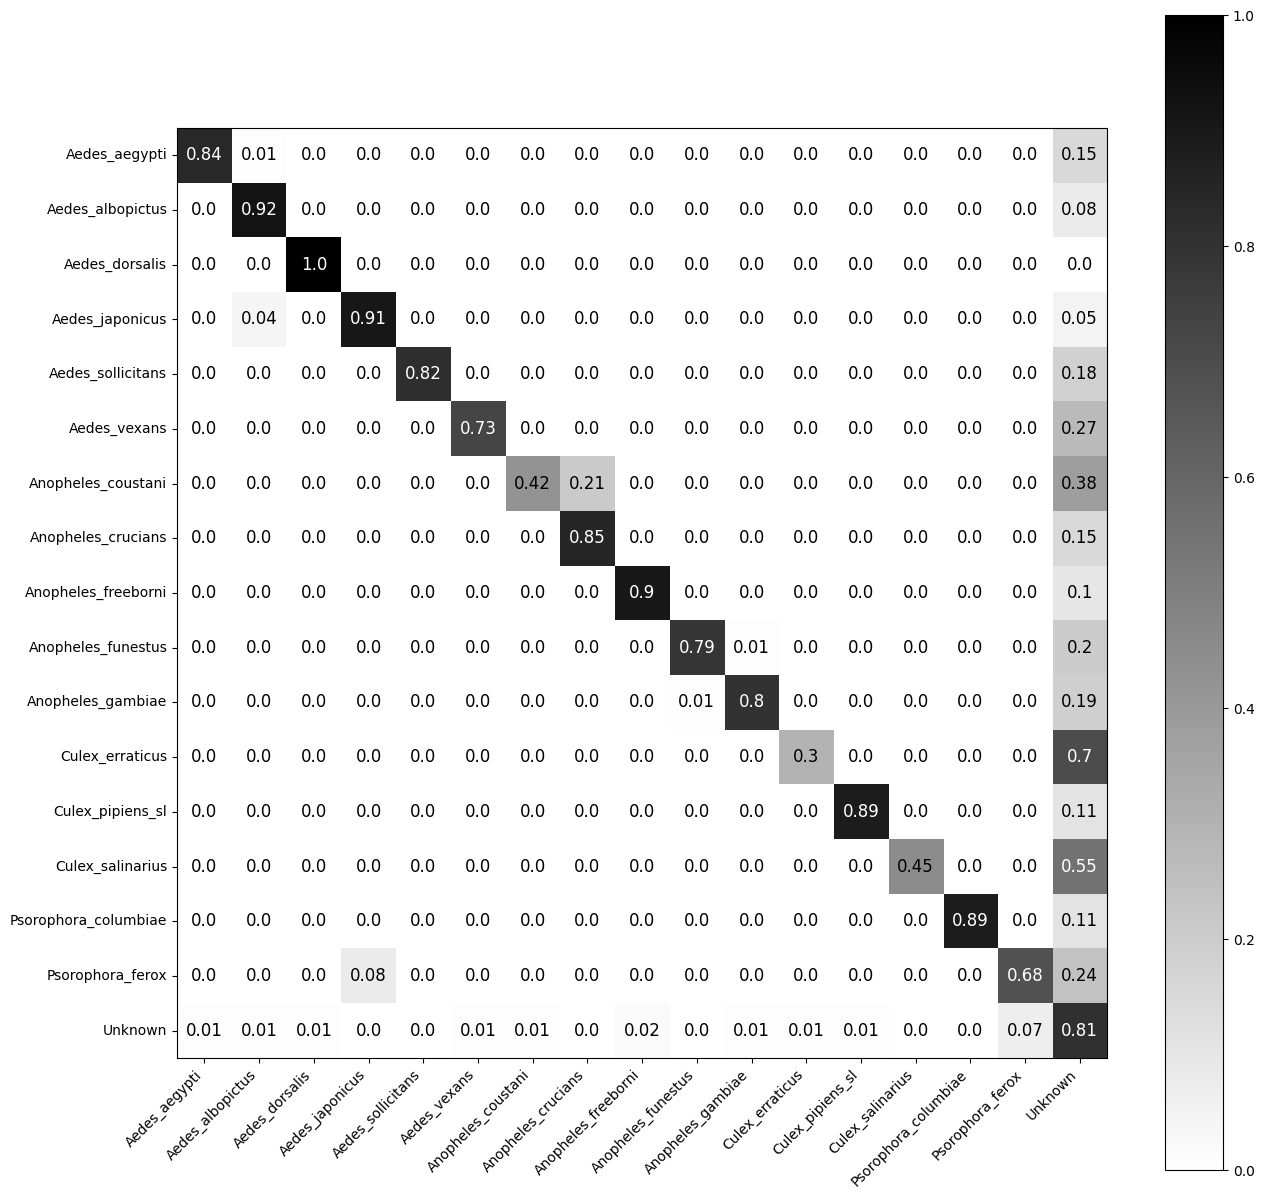

In [29]:
draw_confusion_matrix(cm, class_map.values())

In [30]:
f1_int_macro = f1_score(y_true_int, y_pred_int, average='macro')
pre_int_macro = precision_score(y_true_int, y_pred_int, average='macro')
rec_int_macro = recall_score(y_true_int, y_pred_int, average='macro')

f1_int_micro = f1_score(y_true_int, y_pred_int, average='micro')
pre_int_micro = precision_score(y_true_int, y_pred_int, average='micro')
rec_int_micro = recall_score(y_true_int, y_pred_int, average='micro')

acc_int = accuracy_score(y_true_int, y_pred_int)

In [31]:
metrics = {}
metrics['auroc'] = roc['auroc']
metrics['aupr'] = pr['aupr']

metrics['f1_bin'] = f1_bin
metrics['pre_bin'] = pre_bin
metrics['rec_bin'] = rec_bin
metrics['acc_bin'] = acc_bin

metrics['f1_int_macro'] = f1_int_macro
metrics['pre_int_macro'] = pre_int_macro
metrics['rec_int_macro'] = rec_int_macro

metrics['f1_int_micro'] = f1_int_micro
metrics['pre_int_micro'] = pre_int_micro
metrics['rec_int_micro'] = rec_int_micro

metrics['acc_int'] = acc_int

In [32]:
metrics

{'auroc': 0.8940047961630696,
 'aupr': 0.876092390212478,
 'f1_bin': 0.8349889624724062,
 'pre_bin': 0.8577097505668935,
 'rec_bin': 0.8134408602150538,
 'acc_bin': 0.8235467689583948,
 'f1_int_macro': 0.7463312177788695,
 'pre_int_macro': 0.7592429955623732,
 'rec_int_macro': 0.7656514203794444,
 'f1_int_micro': 0.8179403953968722,
 'pre_int_micro': 0.8179403953968722,
 'rec_int_micro': 0.8179403953968722,
 'acc_int': 0.8179403953968722}

In [33]:
with open(f'results/metrics_{config.fold}.txt', 'w') as file:
    for k, v in metrics.items():
        file.write(f'{k}: {v}\n')